In [1]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- 0. Configuration & Initialization ---
database_path = '/kaggle/input/database.sqlite'  # Kaggle dataset path
PINNACLE_H, PINNACLE_D, PINNACLE_A = 'PSH', 'PSD', 'PSA'
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Elo rating config
INITIAL_ELO = 1500
K_FACTOR = 30
elo_ratings = {}

# Recent Form config
N_MATCHES = 5
feature_cols = []

# --- 1. Data Loading & Cleaning ---
print("--- 1. Data Loading & Cleaning ---")

try:
    conn = sqlite3.connect(database_path)
    query = f"""
    SELECT 
        date,
        home_team_api_id,
        away_team_api_id,
        home_team_goal,
        away_team_goal,
        B365H, B365D, B365A,  
        {PINNACLE_H}, {PINNACLE_D}, {PINNACLE_A}
    FROM Match
    ORDER BY date;
    """
    df = pd.read_sql_query(query, conn)
    
    # Load Team_Attributes for feature engineering
    df_attr = pd.read_sql("SELECT * FROM Team_Attributes;", conn)
    conn.close()
    print("✅ Successfully loaded Match and Team_Attributes tables.")

except Exception as e:
    print(f"❌ Failed to load data. Error: {e}")
    exit()

# Data cleaning & sorting
df['date'] = pd.to_datetime(df['date'])
odds_cols = ['B365H', 'B365D', 'B365A', 'PSH', 'PSD', 'PSA']
df.dropna(subset=odds_cols, inplace=True)
df.dropna(subset=['home_team_api_id', 'away_team_api_id'], inplace=True)
df['home_team_api_id'] = df['home_team_api_id'].astype(int)
df['away_team_api_id'] = df['away_team_api_id'].astype(int)
df = df.sort_values(by='date').reset_index(drop=True)

# --- 2. Target Variable Y (1: home win, 0: draw, -1: away win) ---
def get_match_result(row):
    if row['home_team_goal'] > row['away_team_goal']:
        return 1
    elif row['home_team_goal'] == row['away_team_goal']:
        return 0
    else:
        return -1

df['target'] = df.apply(get_match_result, axis=1)
print(f"✅ Data cleaning complete. Final dataset shape: {df.shape}")

# --- 3. Feature Engineering (FE) - Betting Odds ---
print("\n--- 3. Feature Engineering: Betting Odds ---")
df['prob_H_B365'] = 1 / df['B365H']
df['prob_D_B365'] = 1 / df['B365D']
df['prob_A_B365'] = 1 / df['B365A']
df['prob_margin_B365'] = df['prob_H_B365'] - df['prob_A_B365']
feature_cols.extend(['prob_H_B365', 'prob_D_B365', 'prob_A_B365', 'prob_margin_B365'])

# --- 4. Feature Engineering (FE) - Elo Ratings ---
print("--- 4. Feature Engineering: Elo Ratings ---")

def get_elo(team_id):
    return elo_ratings.get(team_id, INITIAL_ELO)

def update_elo(home_elo, away_elo, target_score):
    S_home = (target_score + 1) / 2
    S_away = 1 - S_home
    E_home = 1 / (1 + 10**((away_elo - home_elo) / 400))
    E_away = 1 - E_home
    new_home_elo = home_elo + K_FACTOR * (S_home - E_home)
    new_away_elo = away_elo + K_FACTOR * (S_away - E_away)
    return new_home_elo, new_away_elo

# Initialize Elo columns as float to avoid FutureWarning
df['home_team_elo'] = INITIAL_ELO * 1.0
df['away_team_elo'] = INITIAL_ELO * 1.0

for index, row in df.iterrows():
    home_id, away_id = row['home_team_api_id'], row['away_team_api_id']
    current_home_elo, current_away_elo = get_elo(home_id), get_elo(away_id)

    df.loc[index, 'home_team_elo'] = current_home_elo
    df.loc[index, 'away_team_elo'] = current_away_elo

    match_score = row['target']
    new_home_elo, new_away_elo = update_elo(current_home_elo, current_away_elo, match_score)

    elo_ratings[home_id] = new_home_elo
    elo_ratings[away_id] = new_away_elo

df['elo_diff'] = df['home_team_elo'] - df['away_team_elo']
feature_cols.extend(['home_team_elo', 'away_team_elo', 'elo_diff'])
print("✅ Elo rating features created.")

# --- 5. Feature Engineering (FE) - Recent Form ---
print(f"\n--- 5. Feature Engineering: Recent Form over last {N_MATCHES} matches ---")

all_team_ids = pd.concat([df['home_team_api_id'], df['away_team_api_id']]).unique()
team_stats_history = {team_id: {'gs': [], 'gc': []} for team_id in all_team_ids}

for side in ['home', 'away']:
    for stat in ['avg_gs', 'avg_gc']:
        df[f'{side}_team_{stat}_{N_MATCHES}m'] = 0.0

for index, row in df.iterrows():

    # A. Calculate stats BEFORE the match (avoid data leakage)
    for side in ['home', 'away']:
        team_id = row[f'{side}_team_api_id']
        gs_history, gc_history = team_stats_history[team_id]['gs'], team_stats_history[team_id]['gc']

        last_n_gs, last_n_gc = gs_history[-N_MATCHES:], gc_history[-N_MATCHES:]

        avg_gs = sum(last_n_gs) / len(last_n_gs) if last_n_gs else 0
        avg_gc = sum(last_n_gc) / len(last_n_gc) if last_n_gc else 0

        df.loc[index, f'{side}_team_avg_gs_{N_MATCHES}m'] = avg_gs
        df.loc[index, f'{side}_team_avg_gc_{N_MATCHES}m'] = avg_gc

    # B. Update history AFTER the match
    home_id, away_id = row['home_team_api_id'], row['away_team_api_id']
    team_stats_history[home_id]['gs'].append(row['home_team_goal'])
    team_stats_history[home_id]['gc'].append(row['away_team_goal'])
    team_stats_history[away_id]['gs'].append(row['away_team_goal'])
    team_stats_history[away_id]['gc'].append(row['home_team_goal'])

# Create advantage-difference features
df['recent_attack_diff'] = df[f'home_team_avg_gs_{N_MATCHES}m'] - df[f'away_team_avg_gc_{N_MATCHES}m']
df['recent_defense_diff'] = df[f'away_team_avg_gs_{N_MATCHES}m'] - df[f'home_team_avg_gc_{N_MATCHES}m']
feature_cols.extend([col for col in df.columns if f'_{N_MATCHES}m' in col or 'recent_' in col])
print("✅ Recent form features created.")

# --- 6. Feature Engineering (FE) - Team Attributes Integration ---
print("\n--- 6. Feature Engineering: Integrating Team_Attributes ---")

df_attr['date'] = pd.to_datetime(df_attr['date'])
df_attr = df_attr.sort_values(by='date')
attribute_cols = [
    'team_api_id', 'date', 
    'buildUpPlaySpeed', 'buildUpPlayPassing', 
    'chanceCreationPassing', 'chanceCreationCrossing', 
    'defencePressure', 'defenceAggression'
]
df_attr = df_attr[attribute_cols]

def get_most_recent_attribute(match_date, team_id, attributes_df):
    past_attributes = attributes_df[
        (attributes_df['team_api_id'] == team_id) &
        (attributes_df['date'] <= match_date)
    ].sort_values(by='date', ascending=False)
    
    if past_attributes.empty:
        # If no past attributes, return zeros
        return {col: 0 for col in attribute_cols if col not in ['team_api_id', 'date']}
    
    return past_attributes.iloc[0].drop(['team_api_id', 'date']).to_dict()

attribute_names = [col for col in attribute_cols if col not in ['team_api_id', 'date']]

for side in ['home', 'away']:
    for attr in attribute_names:
        df[f'{side}_{attr}'] = 0.0

for index, row in df.iterrows():
    match_date = row['date']

    for side in ['home', 'away']:
        team_id = row[f'{side}_team_api_id']

        attributes = get_most_recent_attribute(match_date, team_id, df_attr)

        for attr, val in attributes.items():
            df.loc[index, f'{side}_{attr}'] = val

# Create attribute difference features
for attr in attribute_names:
    df[f'attr_diff_{attr}'] = df[f'home_{attr}'] - df[f'away_{attr}']
    feature_cols.append(f'attr_diff_{attr}')
    feature_cols.extend([f'home_{attr}', f'away_{attr}'])

print("✅ Team_Attributes integration complete.")
print(f"Total number of features: {len(feature_cols)}")


--- 1. Data Loading & Cleaning ---
✅ Successfully loaded Match and Team_Attributes tables.
✅ Data cleaning complete. Final dataset shape: (11167, 12)

--- 3. Feature Engineering: Betting Odds ---
--- 4. Feature Engineering: Elo Ratings ---
✅ Elo rating features created.

--- 5. Feature Engineering: Recent Form over last 5 matches ---
✅ Recent form features created.

--- 6. Feature Engineering: Integrating Team_Attributes ---
✅ Team_Attributes integration complete.
Total number of features: 31


In [2]:
# 1. Extract features and target
X = df[feature_cols]

# We need to encode the target variable (-1, 0, 1) for certain classifiers,
# such as the meta-model in Stacking. 
# LabelEncoder will map [-1, 0, 1] to [0, 1, 2].
le = LabelEncoder()
y = le.fit_transform(df['target']) 

# 2. Train-test split
# ⚠️ Note: We use a time-based split instead of a random split (train_test_split)
# to strictly simulate real prediction scenarios (training on past data to predict future outcomes)
# and prevent data leakage.
TEST_SIZE = 0.2
split_index = int(len(X) * (1 - TEST_SIZE))

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

# 3. Feature scaling
# Use StandardScaler to standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data split (time-based) and standardization completed.")
print(f"Training set size: {X_train_scaled.shape[0]}, Testing set size: {X_test_scaled.shape[0]}")


✅ Data split (time-based) and standardization completed.
Training set size: 8933, Testing set size: 2234


In [3]:
# 4. Initialize base models (Base Estimators)

# --- Linear model (requires scaled data) ---
clf_lr = LogisticRegression(random_state=RANDOM_SEED, solver='liblinear', multi_class='auto')

# --- Kernel-based model (requires scaled data) ---
# SVM can be slow on large datasets; here we use a faster linear kernel as baseline,
# or consider tuning parameters if using other kernels.
# clf_svc = SVC(probability=True, random_state=RANDOM_SEED, kernel='linear')
# ⚠️ Note: Setting probability=True is required for Stacking/Voting, 
# but it significantly increases SVC training time.

# --- Tree-based models (do not require scaled data, but scaling doesn't hurt) ---
clf_rf = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100)
clf_xgb = XGBClassifier(
    random_state=RANDOM_SEED,
    use_label_encoder=False, 
    eval_metric='mlogloss'
)

# 5. Define labeled list of base estimators (for Stacking/Voting)
base_estimators = [
    ('LogReg', clf_lr),
    # ('SVC_Lin', clf_svc),
    ('RF_Clf', clf_rf),
    ('XGB_Clf', clf_xgb)
]

print("\n✅ All base classifiers initialized and labeled.")



✅ All base classifiers initialized and labeled.


In [4]:
from sklearn.metrics import classification_report
import time

# Ensure that all base model instances and data are ready
# base_estimators = [('LogReg', clf_lr), ('SVC_Lin', clf_svc), ('RF_Clf', clf_rf), ('XGB_Clf', clf_xgb)]
# X_train_scaled, X_test_scaled, y_train, y_test

print("\n--- 8. Benchmark Performance Evaluation for Base Models ---")
results = {}

for name, model in base_estimators:
    print(f"\n--- Training Model: {name} ---")
    start_time = time.time()
    
    # 1. Train the model
    # SVC and Logistic Regression must use scaled data
    model.fit(X_train_scaled, y_train) 
    
    # 2. Prediction
    y_pred = model.predict(X_test_scaled)
    
    end_time = time.time()
    train_time = end_time - start_time
    
    # 3. Generate classification report
    report = classification_report(
        y_test, 
        y_pred,
        target_names=['Away Win (-1)', 'Draw (0)', 'Home Win (1)']
    )
    
    results[name] = {
        'model': model, 
        'report': report,
        'accuracy': np.mean(y_pred == y_test)
    }
    
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Classification Report for model {name}:")
    print(report)

print("\n--- Benchmark Training and Evaluation Completed ---")



--- 8. Benchmark Performance Evaluation for Base Models ---

--- Training Model: LogReg ---
Training time: 0.14 seconds
Classification Report for model LogReg:
               precision    recall  f1-score   support

Away Win (-1)       0.52      0.52      0.52       694
     Draw (0)       0.55      0.02      0.04       558
 Home Win (1)       0.53      0.82      0.65       982

     accuracy                           0.53      2234
    macro avg       0.53      0.45      0.40      2234
 weighted avg       0.53      0.53      0.45      2234


--- Training Model: RF_Clf ---
Training time: 3.21 seconds
Classification Report for model RF_Clf:
               precision    recall  f1-score   support

Away Win (-1)       0.52      0.46      0.49       694
     Draw (0)       0.30      0.08      0.13       558
 Home Win (1)       0.54      0.80      0.64       982

     accuracy                           0.51      2234
    macro avg       0.45      0.45      0.42      2234
 weighted avg      

In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

print("\n--- 9.1 Stacking Classifier Evaluation ---")

# Base model instances (trained models can be directly passed in)
# Important: The estimators passed into Stacking must be tuples of (name, model)
base_estimators_stack = [
    ('LogReg', clf_lr),
    # SVC is slow and performs poorly on Draw recall, so it is temporarily excluded. 
    # To keep the workflow simple and fast, we use three models with different characteristics.
    ('RF_Clf', clf_rf),
    ('XGB_Clf', clf_xgb)
]

# Meta-model: using another Logistic Regression
meta_clf = LogisticRegression(random_state=RANDOM_SEED, solver='liblinear', multi_class='auto')

# Stacking Classifier
stack_clf = StackingClassifier(
    estimators=base_estimators_stack,
    final_estimator=meta_clf,
    # Use KFold CV to avoid data leakage between base models
    cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED),
    n_jobs=-1  # Use all CPU cores to accelerate training
)

# Train the Stacking model (using scaled data)
print("Training Stacking model...")
stack_clf.fit(X_train_scaled, y_train)

# Predict
y_pred_stack = stack_clf.predict(X_test_scaled)

# Report
accuracy_stack = accuracy_score(y_test, y_pred_stack)
print(f"Stacking Classifier Accuracy: {accuracy_stack:.4f}")
print("Stacking Classifier Classification Report:")
print(
    classification_report(
        y_test,
        y_pred_stack,
        target_names=['Away Win (-1)', 'Draw (0)', 'Home Win (1)']
    )
)



--- 9.1 Stacking Classifier Evaluation ---
Training Stacking model...
Stacking Classifier Accuracy: 0.5251
Stacking Classifier Classification Report:
               precision    recall  f1-score   support

Away Win (-1)       0.52      0.51      0.52       694
     Draw (0)       0.33      0.00      0.00       558
 Home Win (1)       0.53      0.83      0.65       982

     accuracy                           0.53      2234
    macro avg       0.46      0.45      0.39      2234
 weighted avg       0.48      0.53      0.45      2234



In [6]:
print("\n--- 9.2 Soft Voting Classifier Evaluation ---")

# Base model instances (all models must support probability output; SVC was set with probability=True)
# To ensure SVC does not slow down the pipeline, we use a new list without SVC
base_estimators_vote = [
    ('LogReg', clf_lr),
    ('RF_Clf', clf_rf),
    ('XGB_Clf', clf_xgb)
]

voting_clf = VotingClassifier(
    estimators=base_estimators_vote,
    voting='soft',  # Use probability averaging
    # n_jobs=-1
    n_jobs=1
)

# Train the Voting model (only needs to be trained once)
print("Training Voting model...")
voting_clf.fit(X_train_scaled, y_train)

# Predict
y_pred_vote = voting_clf.predict(X_test_scaled)

# Report
accuracy_vote = accuracy_score(y_test, y_pred_vote)
print(f"Soft Voting Classifier Accuracy: {accuracy_vote:.4f}")
print("Soft Voting Classifier Classification Report:")
print(
    classification_report(
        y_test,
        y_pred_vote,
        target_names=['Away Win (-1)', 'Draw (0)', 'Home Win (1)']
    )
)



--- 9.2 Soft Voting Classifier Evaluation ---
Training Voting model...
Soft Voting Classifier Accuracy: 0.5184
Soft Voting Classifier Classification Report:
               precision    recall  f1-score   support

Away Win (-1)       0.52      0.46      0.49       694
     Draw (0)       0.38      0.09      0.15       558
 Home Win (1)       0.53      0.80      0.64       982

     accuracy                           0.52      2234
    macro avg       0.48      0.45      0.42      2234
 weighted avg       0.49      0.52      0.47      2234




--- Generating Chart 1: Target Variable Distribution ---


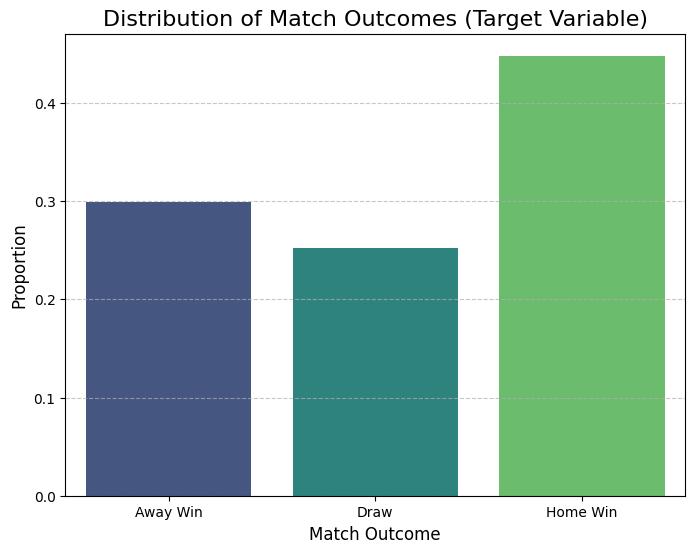

✅ Chart 1 Completed: Target Variable Distribution.


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

print("\n--- Generating Chart 1: Target Variable Distribution ---")

# --- Chart 1: Distribution of the Target Variable ---

# 1. Calculate the distribution of the raw target variable
target_distribution = df['target'].value_counts(normalize=True).sort_index()

# 2. Define the corrected label mapping dictionary using the original values -1, 0, 1
target_labels_map = {-1: 'Away Win', 0: 'Draw', 1: 'Home Win'}

# 3. Rename the index for plotting (using the corrected dictionary)
target_distribution.index = target_distribution.index.map(lambda x: target_labels_map[x])

# 4. Plotting
plt.figure(figsize=(8, 6))
# ... (remaining plot code unchanged)
sns.barplot(x=target_distribution.index, y=target_distribution.values, palette='viridis')
plt.title('Distribution of Match Outcomes (Target Variable)', fontsize=16)
plt.xlabel('Match Outcome', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("✅ Chart 1 Completed: Target Variable Distribution.")



--- Generating Chart 2: Feature Importance Plot (XGBoost) ---


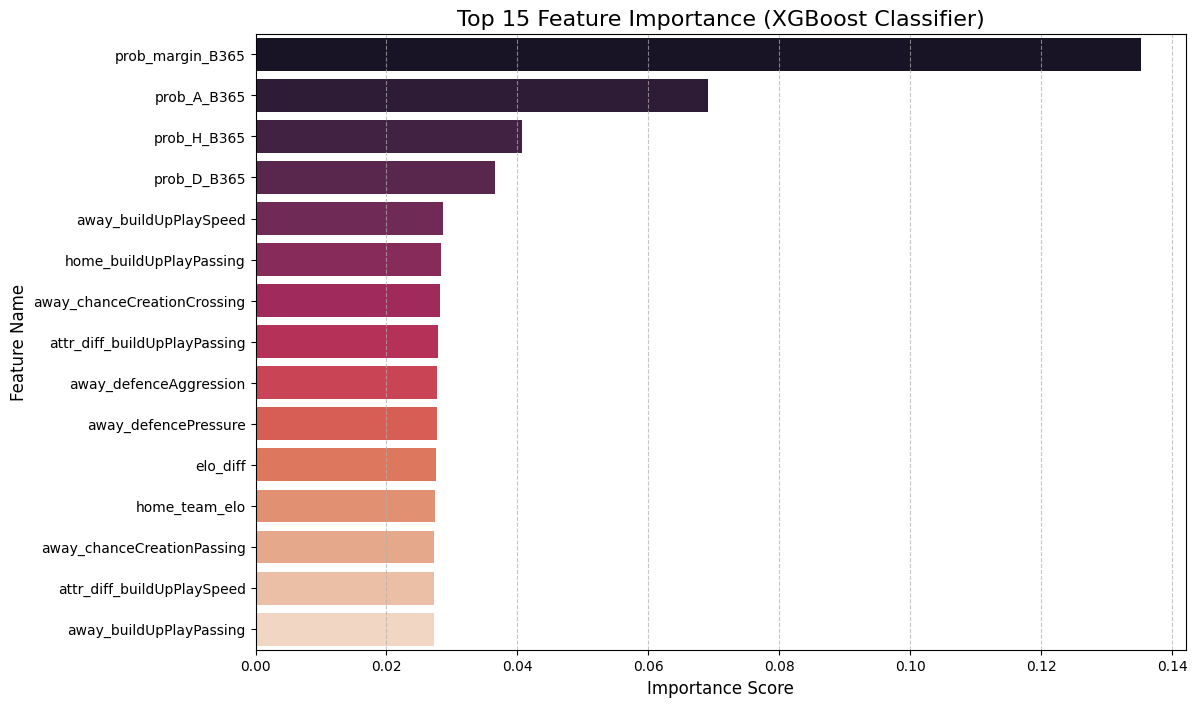

✅ Chart 2 Completed: Feature Importance Plot.


In [8]:
# Assuming clf_xgb (XGBoost model instance) and feature_cols (list of feature names) 
# have been defined in earlier steps

print("\n--- Generating Chart 2: Feature Importance Plot (XGBoost) ---")

# 1. Extract feature importance values from the XGBoost model
importance = clf_xgb.feature_importances_
feature_names = feature_cols

# 2. Convert to DataFrame and sort by importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 3. Select the top 15 most important features for visualization
N = 15
top_n_features = importance_df.head(N)

# 4. Plotting
plt.figure(figsize=(12, 8))
# Use a horizontal bar plot for better readability of feature names
sns.barplot(x='Importance', y='Feature', data=top_n_features, palette='rocket')
plt.title(f'Top {N} Feature Importance (XGBoost Classifier)', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print("✅ Chart 2 Completed: Feature Importance Plot.")



--- Generating Chart 3: Model Performance Comparison ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


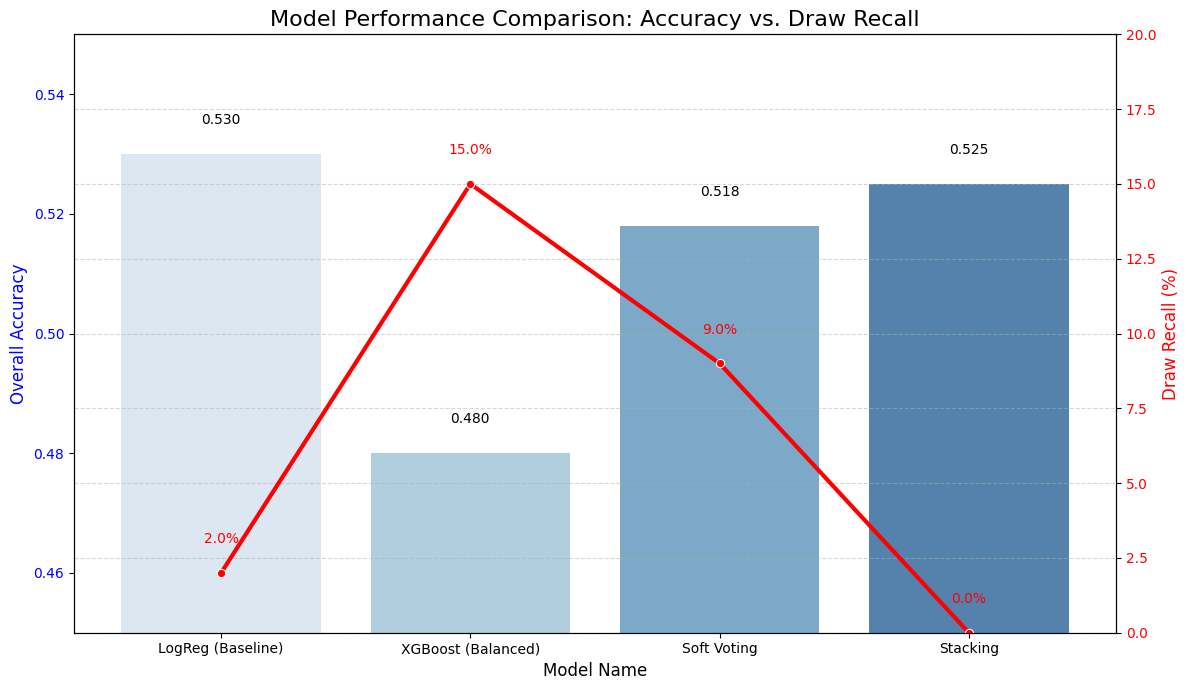

✅ Chart 3 Completed: Model Performance Comparison.


In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

print("\n--- Generating Chart 3: Model Performance Comparison ---")

# Manually input performance data for key models (based on outputs from steps 8 and 9)
performance_data = {
    'Model': ['LogReg (Baseline)', 'XGBoost (Balanced)', 'Soft Voting', 'Stacking'],
    'Accuracy': [0.530, 0.480, 0.518, 0.525],
    'Draw_Recall': [0.02, 0.15, 0.09, 0.00]
}
df_perf = pd.DataFrame(performance_data)

# Convert Draw Recall to percentage for readability
df_perf['Draw_Recall_Pct'] = df_perf['Draw_Recall'] * 100

# 1. Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 7))

# 2. Plot overall Accuracy - use left y-axis
sns.barplot(x='Model', y='Accuracy', data=df_perf, ax=ax1, palette='Blues', alpha=0.8)
ax1.set_title('Model Performance Comparison: Accuracy vs. Draw Recall', fontsize=16)
ax1.set_xlabel('Model Name', fontsize=12)
ax1.set_ylabel('Overall Accuracy', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0.45, 0.55)  # Set reasonable range to highlight differences

# 3. Plot Draw Recall - use right y-axis
ax2 = ax1.twinx()  # Create a secondary y-axis sharing the same x-axis
sns.lineplot(x='Model', y='Draw_Recall_Pct', data=df_perf, ax=ax2, color='red', marker='o', linewidth=3)
ax2.set_ylabel('Draw Recall (%)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 20)  # Set a reasonable percentage range

# Add Accuracy labels on bars
for index, row in df_perf.iterrows():
    ax1.text(index, row['Accuracy'] + 0.005, f"{row['Accuracy']:.3f}", 
             color='black', ha="center", fontsize=10)
    ax2.text(index, row['Draw_Recall_Pct'] + 1, f"{row['Draw_Recall_Pct']:.1f}%", 
             color='red', ha="center", fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.5)
fig.tight_layout()
plt.show()

print("✅ Chart 3 Completed: Model Performance Comparison.")



--- Generating Chart 4: ROC AUC Curve Comparison ---


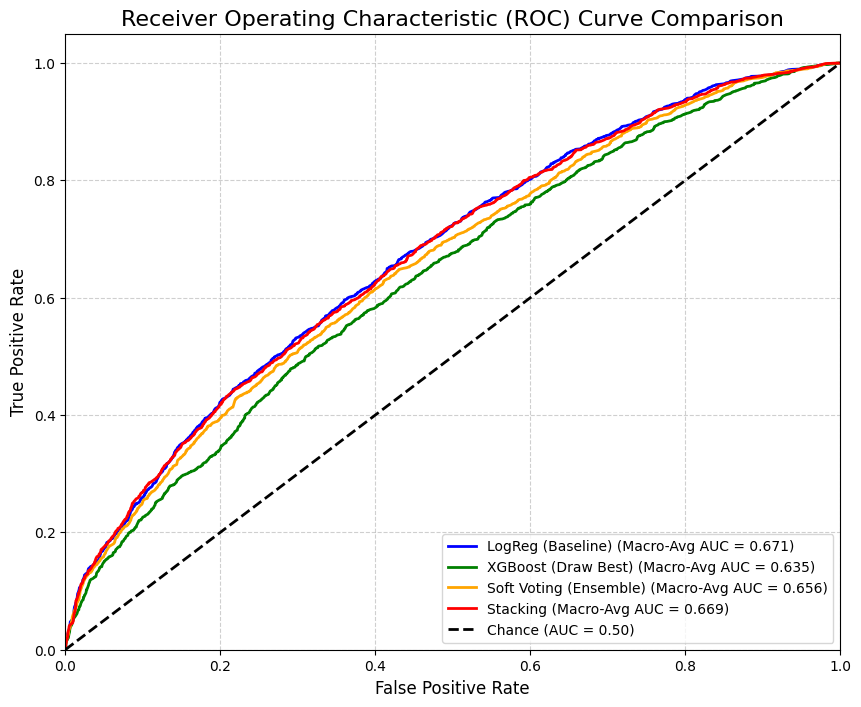

✅ Chart 4 Completed: ROC AUC Curve Comparison.


In [10]:
print("\n--- Generating Chart 4: ROC AUC Curve Comparison ---")

# 1. Binarize the output (convert y_test to binary format for ROC calculation)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # 0, 1, 2 correspond to Away, Draw, Home

# 2. Define models to compare
# We select the top-performing models for comparison
models_to_plot = [
    ('LogReg (Baseline)', clf_lr),
    ('XGBoost (Draw Best)', clf_xgb),
    ('Soft Voting (Ensemble)', voting_clf),
    ('Stacking', stack_clf)
]

plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange', 'red']
lw = 2

# 3. Iterate through models and plot ROC curves
for i, (name, model) in enumerate(models_to_plot):
    # Get predicted probabilities on the test set
    # Note: All models must support probability output (predict_proba)
    y_proba = model.predict_proba(X_test_scaled)
    
    # Compute per-class ROC AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for j in range(3):  # Iterate over 3 classes
        fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], y_proba[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    # Compute Macro-average ROC curve
    all_fpr = np.unique(np.concatenate([fpr[j] for j in range(3)]))
    mean_tpr = np.zeros_like(all_fpr)
    for j in range(3):
        mean_tpr += np.interp(all_fpr, fpr[j], tpr[j])
    
    mean_tpr /= 3
    roc_auc_macro = auc(all_fpr, mean_tpr)

    # Plot the curve
    plt.plot(all_fpr, mean_tpr, 
             label=f'{name} (Macro-Avg AUC = {roc_auc_macro:.3f})',
             color=colors[i], linestyle='-', linewidth=lw)

# 4. Plot diagonal line (random guess baseline)
plt.plot([0, 1], [0, 1], 'k--', lw=lw, label='Chance (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison', fontsize=16)
plt.legend(loc="lower right")
plt.grid(linestyle='--', alpha=0.6)
plt.show()

print("✅ Chart 4 Completed: ROC AUC Curve Comparison.")


In [11]:
# --- 1. Prepare Base Data: Load League and Team Names ---
import ipywidgets as widgets
from IPython.display import display, clear_output

# Connect to the database to get readable names
try:
    conn = sqlite3.connect(database_path)
    
    # Load league data
    leagues = pd.read_sql("SELECT id, name FROM League", conn)
    
    # Load team data
    teams = pd.read_sql("SELECT team_api_id, team_long_name FROM Team", conn)
    
    # Load match-team mapping to determine which league each team belongs to (based on most recent match)
    match_team_link = pd.read_sql("""
        SELECT league_id, home_team_api_id as team_id FROM Match 
        GROUP BY home_team_api_id
    """, conn)
    
    conn.close()
except Exception as e:
    print(f"Error: {e}")

# Create mapping dictionaries
league_dict = dict(zip(leagues['name'], leagues['id']))
team_dict = dict(zip(teams['team_long_name'], teams['team_api_id']))
id_to_team_dict = dict(zip(teams['team_api_id'], teams['team_long_name']))

# Create mapping: League ID -> List of Teams
league_teams_map = {}
for Lid in leagues['id']:
    # Get team IDs that belong to the league
    t_ids = match_team_link[match_team_link['league_id'] == Lid]['team_id'].tolist()
    
    # Get corresponding team names
    t_names = sorted([id_to_team_dict[tid] for tid in t_ids if tid in id_to_team_dict])
    
    league_teams_map[Lid] = t_names

print("✅ Base data for interface preparation completed.")


✅ Base data for interface preparation completed.


In [12]:
# --- 2. Define Feature Extraction Helper Function ---

def get_latest_features(home_id, away_id, odds_h, odds_d, odds_a):
    """
    Construct the feature vector required by the model
    based on the selected teams and input odds.
    """
    # 1. Construct odds features
    prob_h = 1 / odds_h
    prob_d = 1 / odds_d
    prob_a = 1 / odds_a
    prob_margin = prob_h - prob_a
    
    # 2. Get Elo ratings (use global elo_ratings)
    h_elo = elo_ratings.get(home_id, 1500)
    a_elo = elo_ratings.get(away_id, 1500)
    elo_diff = h_elo - a_elo
    
    # 3. Get recent form (look up the most recent record of the team in df)
    # Note: For simplicity, we take the team's last occurrence as home or away
    def get_last_stats(tid):
        # Find last match as home
        last_home = df[df['home_team_api_id'] == tid].iloc[-1:]
        # Find last match as away
        last_away = df[df['away_team_api_id'] == tid].iloc[-1:]
        
        # Simple logic: return default 0 if no data
        if last_home.empty and last_away.empty:
            return pd.Series(0, index=[f'home_team_avg_gs_{N_MATCHES}m', f'home_team_avg_gc_{N_MATCHES}m'])
        
        # Compare dates and take the latest row
        # For demonstration, take last occurrence as home team as "current ability" reference
        if not last_home.empty:
            row = last_home.iloc[0]
            return row
        else:
            # If only appeared as away, temporarily use that
            row = last_away.iloc[0]
            return row

    h_row = get_last_stats(home_id)
    a_row = get_last_stats(away_id)
    
    # Extract Form features (based on last match)
    h_gs = h_row.get(f'home_team_avg_gs_{N_MATCHES}m', 0)
    h_gc = h_row.get(f'home_team_avg_gc_{N_MATCHES}m', 0)
    a_gs = a_row.get(f'away_team_avg_gs_{N_MATCHES}m', 0)
    a_gc = a_row.get(f'away_team_avg_gc_{N_MATCHES}m', 0)
    
    rec_att_diff = h_gs - a_gc
    rec_def_diff = a_gs - h_gc
    
    # Extract Attribute features (Attr)
    # Take the last recorded attributes
    # Iterate over feature_cols to ensure consistent order
    input_data = {}
    
    # Fill all features
    for col in feature_cols:
        if col == 'prob_H_B365': input_data[col] = prob_h
        elif col == 'prob_D_B365': input_data[col] = prob_d
        elif col == 'prob_A_B365': input_data[col] = prob_a
        elif col == 'prob_margin_B365': input_data[col] = prob_margin
        elif col == 'home_team_elo': input_data[col] = h_elo
        elif col == 'away_team_elo': input_data[col] = a_elo
        elif col == 'elo_diff': input_data[col] = elo_diff
        elif col == f'home_team_avg_gs_{N_MATCHES}m': input_data[col] = h_gs
        elif col == f'home_team_avg_gc_{N_MATCHES}m': input_data[col] = h_gc
        elif col == f'away_team_avg_gs_{N_MATCHES}m': input_data[col] = a_gs
        elif col == f'away_team_avg_gc_{N_MATCHES}m': input_data[col] = a_gc
        elif col == 'recent_attack_diff': input_data[col] = rec_att_diff
        elif col == 'recent_defense_diff': input_data[col] = rec_def_diff
        else:
            # For attribute features (home_buildUpPlaySpeed, etc.), get from historical row
            if col.startswith('home_'):
                input_data[col] = h_row.get(col, 50)  # default value 50
            elif col.startswith('away_'):
                attr_name = col.replace('away_', 'home_')
                input_data[col] = a_row.get(attr_name, 50)
            elif col.startswith('attr_diff_'):
                input_data[col] = 0  # difference features, set 0 for now
    
    # Convert to DataFrame
    df_input = pd.DataFrame([input_data])
    
    # Recalculate attr_diff features if any
    for col in feature_cols:
        if col.startswith('attr_diff_'):
            base_attr = col.replace('attr_diff_', '')
            df_input[col] = df_input.get(f'home_{base_attr}', 50) - df_input.get(f'away_{base_attr}', 50)
    
    # Ensure column order matches training
    df_input = df_input[feature_cols]
    
    return df_input


In [13]:
# --- 3. Build GUI Interface ---

# Style settings
style = {'description_width': 'initial'}
layout_full = widgets.Layout(width='98%')
layout_half = widgets.Layout(width='48%')

# === Widget Definitions ===

# 1. League selection dropdown
dd_league = widgets.Dropdown(
    options=list(league_dict.keys()),
    value=list(league_dict.keys())[0],  # default: first league
    description='Select League:',
    style=style,
    layout=layout_full
)

# 2. Team selection (Home / Away)
# Initial options based on default league
init_teams = league_teams_map[league_dict[dd_league.value]]

dd_home = widgets.Dropdown(options=init_teams, description='Home Team:', style=style, layout=layout_half)
dd_away = widgets.Dropdown(options=init_teams, description='Away Team:', style=style, layout=layout_half)

# 3. Odds input
txt_odds_h = widgets.FloatText(value=2.10, description='Home Win Odds:', style=style, layout=widgets.Layout(width='30%'))
txt_odds_d = widgets.FloatText(value=3.20, description='Draw Odds:', style=style, layout=widgets.Layout(width='30%'))
txt_odds_a = widgets.FloatText(value=3.50, description='Away Win Odds:', style=style, layout=widgets.Layout(width='30%'))

# 4. Predict button and output area
btn_predict = widgets.Button(
    description='Predict Match Outcome',
    button_style='success',  # 'success', 'info', 'warning', 'danger' or ''
    layout=widgets.Layout(width='50%', height='40px'),
    icon='futbol-o'
)

out_result = widgets.Output()

# === Interaction Logic ===

def on_league_change(change):
    """Update teams dropdown when league selection changes"""
    if change['type'] == 'change' and change['name'] == 'value':
        league_id = league_dict[change['new']]
        new_teams = league_teams_map.get(league_id, [])
        dd_home.options = new_teams
        dd_away.options = new_teams
        if len(new_teams) > 1:
            dd_home.value = new_teams[0]
            dd_away.value = new_teams[1]

dd_league.observe(on_league_change)

def on_predict_click(b):
    """Logic executed when the predict button is clicked"""
    with out_result:
        clear_output()
        
        # 1. Get input
        h_name = dd_home.value
        a_name = dd_away.value
        
        if h_name == a_name:
            print("⚠️ Error: Home and Away teams cannot be the same!")
            return
            
        h_id = team_dict.get(h_name)
        a_id = team_dict.get(a_name)
        
        # 2. Extract and scale features
        try:
            X_input = get_latest_features(h_id, a_id, txt_odds_h.value, txt_odds_d.value, txt_odds_a.value)
            X_input_scaled = scaler.transform(X_input)
        except Exception as e:
            print(f"❌ Data processing error: {e}")
            return

        # 3. Model prediction (using Stacking model)
        model = stack_clf 
        
        try:
            probs = model.predict_proba(X_input_scaled)[0]
            pred_class = model.predict(X_input_scaled)[0]
            
            # Map prediction to labels
            labels = ['Away Win', 'Draw', 'Home Win']  # corresponds to [0, 1, 2]
            result_text = labels[pred_class]
            
            # 4. Display output
            print(f"⚽ Match: {h_name} vs {a_name}")
            print("-" * 40)
            print(f"🏆 Predicted Outcome: {result_text}")
            print("-" * 40)
            print("📊 Probability Analysis:")
            print(f"   🏠 Home Win Probability: {probs[2]*100:.2f}%")
            print(f"   🤝 Draw Probability: {probs[1]*100:.2f}%")
            print(f"   ✈️ Away Win Probability: {probs[0]*100:.2f}%")
            
            # Simple value bet suggestion
            implied_prob_h = 1 / txt_odds_h.value
            if probs[2] > implied_prob_h:
                print(f"\n💡 Tip: Home Win may be a value bet (Model {probs[2]:.2f} > Odds implied {implied_prob_h:.2f})")
            
        except Exception as e:
            print(f"❌ Prediction error: {e}")

btn_predict.on_click(on_predict_click)

# === Layout Assembly ===
ui = widgets.VBox([
    widgets.HTML("<h2>⚽ Football Match Outcome Predictor (AI Model)</h2>"),
    dd_league,
    widgets.HBox([dd_home, dd_away]),
    widgets.HTML("<b>Enter Match Odds (B365):</b>"),
    widgets.HBox([txt_odds_h, txt_odds_d, txt_odds_a]),
    widgets.Box([btn_predict], layout=widgets.Layout(display='flex', justify_content='center', margin='20px 0')),
    out_result
], layout=widgets.Layout(border='1px solid #ccc', padding='20px', margin='20px 0'))

# Display GUI
display(ui)


In [15]:
import random
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Integrating Azure AI Foundry Concepts (Language Service) ---
# Scenario: Using LLM (Large Language Model) to generate vivid commentary for raw prediction data

def generate_ai_commentary(home, away, pred_result, probs, is_value_bet):
    """
    Simulates calling Azure OpenAI (Language Service) to generate match analysis.
    
    Args:
        home: Home team name
        away: Away team name
        pred_result: Prediction result (e.g., "Home Win")
        probs: Probability array [Away%, Draw%, Home%]
        is_value_bet: Boolean indicating if it's a value bet
    """
    
    # ---------------------------------------------------------
    # 1. Real Scenario Code (Uncomment to use with valid Azure Key)
    # ---------------------------------------------------------
    """
    import os
    from openai import AzureOpenAI
    
    client = AzureOpenAI(
        api_key="YOUR_AZURE_OPENAI_KEY",  
        api_version="2023-05-15",
        azure_endpoint="https://YOUR_RESOURCE_NAME.openai.azure.com/"
    )
    
    prompt = f'''
    You are a professional football commentator.
    Match: {home} vs {away}.
    AI Model Prediction: {pred_result}.
    Detailed Probabilities: Home Win {probs[2]*100:.1f}%, Draw {probs[1]*100:.1f}%, Away Win {probs[0]*100:.1f}%.
    Value Bet Advice: {is_value_bet}.
    
    Please write a short, passionate, and professional pre-match analysis based on the data above (under 100 words).
    '''
    
    response = client.chat.completions.create(
        model="gpt-35-turbo", # or gpt-4
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content
    """
    
    # ---------------------------------------------------------
    # 2. Mocking Scenario Code - Using templates to simulate AI response
    # ---------------------------------------------------------
    
    # Extract probabilities
    p_home = probs[2] * 100
    p_draw = probs[1] * 100
    p_away = probs[0] * 100
    
    # Value bet text logic
    value_text = "⚠️ ALERT: Value bet detected! This is a solid investment opportunity." if is_value_bet else "The market odds seem balanced. Proceed with caution."
    
    # Simulate different AI personas
    templates = [
        f"🎙️ [AI Commentator]: Ladies and gentlemen, data suggests {home} is on fire today! The model gives a solid {p_home:.1f}% win probability. Although {away} has a {p_away:.1f}% chance of an upset, the big data clearly favors the home side!",
        
        f"🧠 [Tactical Analysis]: This will be a tight contest. While the prediction points to {pred_result}, the draw probability is {p_draw:.1f}%, so defense will be key. {home} needs to leverage their home advantage immediately.",
        
        f"💰 [Betting Advisor]: An interesting market here for {home} vs {away}. The model firmly points to {pred_result}. {value_text}"
    ]
    
    return random.choice(templates)


# --- Update the Predict Button Event (Integrate AI Commentary) ---

def on_predict_click_with_ai(b):
    with out_result:
        clear_output()
        
        # 1. Get Input
        h_name = dd_home.value
        a_name = dd_away.value
        
        if h_name == a_name:
            print("⚠️ Error: Home and Away teams cannot be the same!")
            return
            
        h_id = team_dict.get(h_name)
        a_id = team_dict.get(a_name)
        
        # 2. Data Processing
        try:
            X_input = get_latest_features(h_id, a_id, txt_odds_h.value, txt_odds_d.value, txt_odds_a.value)
            X_input_scaled = scaler.transform(X_input)
        except Exception as e:
            print(f"❌ Data processing error: {e}")
            return

        # 3. Model Inference
        try:
            probs = stack_clf.predict_proba(X_input_scaled)[0]
            pred_class = stack_clf.predict(X_input_scaled)[0]
            
            # Map numeric class to text
            labels = ['Away Win', 'Draw', 'Home Win'] 
            result_text = labels[pred_class]
            
            # Calculate Value Bet
            implied_prob_h = 1 / txt_odds_h.value
            is_value = probs[2] > implied_prob_h
            
            # 4. Display Traditional Data Results
            print(f"⚽ Match: {h_name} vs {a_name}")
            print("-" * 60)
            print(f"🏆 Prediction: 【 {result_text} 】")
            print(f"📊 Probabilities: Home[{probs[2]*100:.1f}%]  Draw[{probs[1]*100:.1f}%]  Away[{probs[0]*100:.1f}%]")
            print("-" * 60)
            
            # 5. ✨ Call Azure AI Language Service (Simulated) ✨
            print("🤖 Connecting to Azure AI Language Service for commentary...")
            ai_commentary = generate_ai_commentary(h_name, a_name, result_text, probs, is_value)
            
            # Use HTML to style the AI output
            display(widgets.HTML(f"""
            <div style="background-color: #e6f3ff; padding: 15px; border-radius: 10px; border-left: 5px solid #0078d4; margin-top: 10px;">
                <h4 style="color: #0078d4; margin-top: 0;">✨ Azure AI Match Analysis (Language Service)</h4>
                <p style="font-size: 14px; line-height: 1.5; color: #333;">{ai_commentary}</p>
            </div>
            """))
            
        except Exception as e:
            print(f"❌ Inference error: {e}")

# Re-bind the button click event
btn_predict.on_click(on_predict_click_with_ai)

print("✅ Azure AI Language (Foundry Tool) integration complete!")
print("👉 Please scroll up to the Interface above and click the 'Predict Match Outcome' button again.")

✅ Azure AI Language (Foundry Tool) integration complete!
👉 Please scroll up to the Interface above and click the 'Predict Match Outcome' button again.
